In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm

from swarm_sim import *

%matplotlib inline 

In [2]:
# 1st dataset: N=50
PATH = '..\\..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
EXPORT_PATH = '..\\output\\data\\'
ROW_DATA = 7

NB_NODES = 50
DURATION = 8641 # Number of data rows, not time!
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km

SAMPLE_STEP = 12


In [3]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<ROW_DATA, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total=REVOLUTION, desc='Converting to topologies') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix()
        pbar.update(1)

topo_graphs = {} # Dict{timestamp: Graph}
with tqdm(total=REVOLUTION, desc='Converting to NetworkX graphs') as pbar:
    for t in range(REVOLUTION):
        topo_graphs[t] = swarm_data[t].swarm_to_nxgraph()
        pbar.update(1)

Converting to NetworkX graphs: 100%|██████████| 1800/1800 [00:06<00:00, 284.54it/s]


## Temporal evolution

We compute metrics on the original (undivided) graph, then re-compute them on the divided graph (see algos below). The comparison is performed with the variation coefficient (VC), which is the ratio of standard deviation to average.

Analysed metrics for comparison to the original graph (VC: the average value is that of the original graph):
- Average degree (AD): number of direct neighbor(s) for each node, averaged
- Average clustering coefficient (ACC): ratio of observed edges in the neighborhood over maximum possible number of edges, averaged
- Average betweenness centrality (ABC), normalized: number of shortest paths passing through a node, averaged

Analyzed metrics for comparison between algorithms (VC: the average value is NB_NODES/NB_GROUPS):
- Network size (NS): number of nodes per group

Implemented algorithms:
- Random Node Division (RND)
- Multiple Independent Random Walks (MIRW)
- Forest Fire Division (FFD)

In [4]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_acc, ref_abc = [], [], []

with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Reference metrics') as pbar:
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        graph = topo_graphs[t]
        ref_ad.append(np.mean(nx.degree(graph)))
        ref_acc.append(nx.average_clustering(graph))
        ref_abc.append(np.mean(list(nx.betweenness_centrality(graph).values())))
        pbar.update(1)

Reference metrics: 100%|██████████| 150/150.0 [00:00<00:00, 159.51it/s]


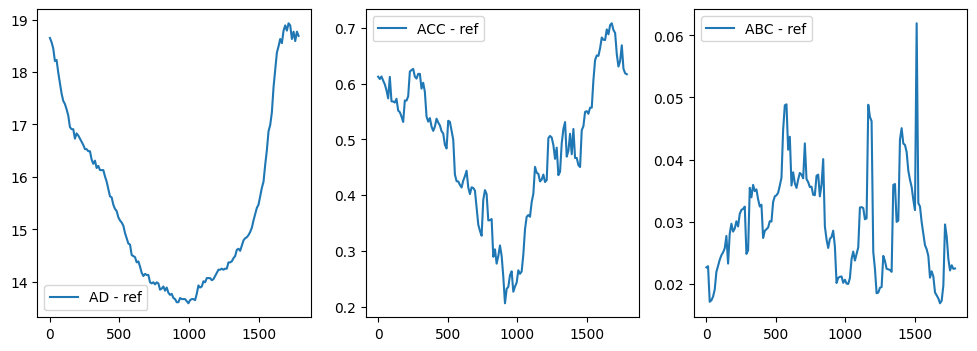

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
idx = np.arange(0, REVOLUTION, SAMPLE_STEP)

ax = axes[0]
ax.plot(idx, ref_ad, label='AD - ref')
ax.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='ACC - ref')
ax.legend()

ax = axes[2]
ax.plot(idx, ref_abc, label='ABC - ref')
ax.legend()

In [5]:
def variance(data, mean=None):
    if mean == None:
        mean = np.mean(data)
    return np.mean([(d - mean)**2 for d in data])

def variation_coef(data, mean=None):
    if mean != 0:
        var = variance(data, mean)
        return np.sqrt(var)/mean
    print('Error: mean is null.')
    return -1

def rmse(data, ref=None): # Compare the observed distribution to a reference value
    if ref == None:
        ref = np.mean(data)
    errors = [(e-ref)**2 for e in data]
    ratio = sum(errors)/len(data)
    return np.sqrt(ratio)

## 1. Analysis of Network Size

In [6]:
NB_REPETITIONS = 30

In [8]:
nb_groups = np.arange(1,NB_NODES+1)
varcoefs_rnd = []
varcoefs_mirw = []
varcoefs_ffd = []

for nb in nb_groups:
    ref_ns = NB_NODES/nb
    print('Testing RND')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].RND(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_rnd.append(rmse(ns, ref_ns))
    print('Testing MIRW')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].MIRW(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_mirw.append(rmse(ns, ref_ns))
    print('Testing FFD')
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].FFD(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_ffd.append(rmse(ns, ref_ns))

Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
Testing RND
Testing MIRW
Testing FFD
T

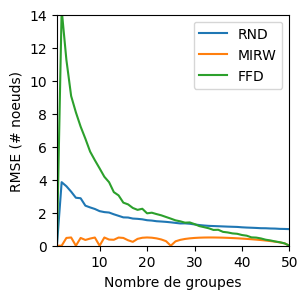

In [9]:
plt.figure(figsize=(3,3))

plt.plot(nb_groups, varcoefs_rnd, label='RND')
plt.plot(nb_groups, varcoefs_mirw, label='MIRW')
plt.plot(nb_groups, varcoefs_ffd, label='FFD')
plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (# noeuds)')
plt.xlim(1,50)
plt.ylim(0,14)
plt.legend()

## 2. Analyse du diamètre

In [4]:
graph = topo_graphs[0]

In [18]:
def diameter(graph):
    connected_components = [cc for cc in nx.connected_components(graph)]
    diameters = []
    for cc in connected_components:
        subg = nx.induced_subgraph(graph, cc)
        dia = nx.diameter(subg)
        diameters.append(dia)
    return diameters

def group_diameter(graph, group):
    dia = 0
    for ni in group:
            for nj in group:
                if nx.has_path(graph, ni, nj):
                    spl = nx.shortest_path_length(graph, ni, nj)
                    if spl > dia:
                        dia = spl
    return dia
    

In [14]:
ref_dia_max = []

with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Reference diameters') as pbar:
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        graph = topo_graphs[t]
        diameters = diameter(graph)
        ref_dia_max.append(max(diameters))
        pbar.update(1)

Reference diameters: 100%|██████████| 150/150.0 [00:02<00:00, 56.68it/s] 


In [36]:
NB_GROUPS = np.arange(1, NB_NODES+1)

with tqdm(total=len(NB_GROUPS), desc='Number of groups RND') as pbar:
    group_dia_rnd = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].RND(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        group_dia_max = []
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            max_dias = [group_diameter(graph, gr) for gr in groups.values()]
            group_dia_max.append(np.mean(max_dias))
        
        group_dia_rnd[nb_group] = np.mean(group_dia_max)
        pbar.update(1)
        
        
with tqdm(total=len(NB_GROUPS), desc='Number of groups MIRW') as pbar:
    group_dia_mirw = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].MIRW(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        group_dia_max = []
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            max_dias = [group_diameter(graph, gr) for gr in groups.values()]
            group_dia_max.append(np.mean(max_dias))
        
        group_dia_mirw[nb_group] = np.mean(group_dia_max)
        pbar.update(1)
        
        
with tqdm(total=len(NB_GROUPS), desc='Number of groups FFD') as pbar:
    group_dia_ffd = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].FFD(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        group_dia_max = []
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            max_dias = [group_diameter(graph, gr) for gr in groups.values()]
            group_dia_max.append(np.mean(max_dias))
        
        group_dia_ffd[nb_group] = np.mean(group_dia_max)
        pbar.update(1)

Number of groups FFD: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


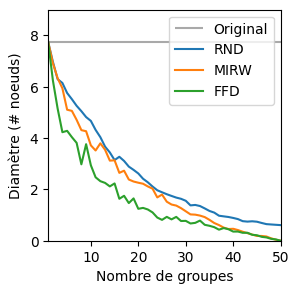

In [39]:
plt.figure(figsize=(3,3))
idx = np.arange(1, NB_NODES+1)

plt.hlines(y=np.mean(ref_dia_max), xmin=1, xmax=50, colors='darkgray', label='Original')
plt.plot(idx, group_dia_rnd.values(), label='RND')
plt.plot(idx, group_dia_mirw.values(), label='MIRW')
plt.plot(idx, group_dia_ffd.values(), label='FFD')
plt.xlim(1,50)
plt.ylim(0,9)
plt.xlabel('Nombre de groupes')
plt.ylabel('Diamètre (# noeuds)')
plt.legend()

## 3. Routing cost

In [40]:
def routing_cost(graph, group=None):
    cost = 0
    nodes = graph.nodes
    if group:
        nodes = group
    for src in nodes:
        for dst in nodes:
            if nx.has_path(graph, src, dst):
                cost += nx.shortest_path_length(graph, src, dst)
    return cost

In [43]:
ref_rcost = []
for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
    graph = topo_graphs[t]
    ref_rcost.append(routing_cost(graph))

In [48]:
NB_GROUPS = np.arange(1, NB_NODES+1)

with tqdm(total=len(NB_GROUPS), desc='Number of groups RND') as pbar:
    group_rcost_rnd = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].RND(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        rcost_rnd = []
        cost_inter = len(groups.keys())*(len(groups.keys())-1)
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            group_rcost = [routing_cost(graph, gr) for gr in groups.values()]
            rcost_rnd.append(sum(group_rcost)+cost_inter)
        
        group_rcost_rnd[nb_group] = np.mean(rcost_rnd)
        pbar.update(1)
        
        
with tqdm(total=len(NB_GROUPS), desc='Number of groups MIRW') as pbar:
    group_rcost_mirw = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].MIRW(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        rcost_mirw = []
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            group_rcost = [routing_cost(graph, gr) for gr in groups.values()]
            rcost_mirw.append(sum(group_rcost)+cost_inter)
        
        group_rcost_mirw[nb_group] = np.mean(rcost_mirw)
        pbar.update(1)
        
        
with tqdm(total=len(NB_GROUPS), desc='Number of groups MIRW') as pbar:
    group_rcost_ffd = {}
    for nb_group in NB_GROUPS:
        swarm_data[0].reset_groups()
        groups = swarm_data[0].FFD(n=nb_group, s=1, by_id=True)# <==================== ALGO CHOICE 
        rcost_ffd = []
        
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]
            group_rcost = [routing_cost(graph, gr) for gr in groups.values()]
            rcost_ffd.append(sum(group_rcost)+cost_inter)
        
        group_rcost_ffd[nb_group] = np.mean(rcost_ffd)
        pbar.update(1)

Number of groups RND:   0%|          | 0/50 [00:00<?, ?it/s]

Number of groups RND:  90%|█████████ | 45/50 [17:08<01:54, 22.86s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(3,3))
idx = np.arange(1, NB_NODES+1)

plt.hlines(y=np.mean(ref_rcost), xmin=1, xmax=50, colors='darkgray', label='Original')
plt.plot(idx, group_rcost_rnd.values(), label='RND')
plt.plot(idx, group_rcost_mirw.values(), label='MIRW')
plt.plot(idx, group_rcost_ffd.values(), label='FFD')
plt.xlim(1,50)
plt.ylim(0,9)
plt.xlabel('Nombre de groupes')
plt.ylabel('Coût de routage')
plt.legend()